# 8.3. Network in Network (NiN)
8.3. Rede em Rede (NiN)


LeNet, AlexNet e VGG compartilham um padrão de design comum: extrair recursos explorando a estrutura espacial por meio de uma sequência de convoluções e camadas de agrupamento e pós-processar as representações por meio de camadas totalmente conectadas. As melhorias no LeNet por AlexNet e VGG residem principalmente em como essas redes posteriores ampliam e aprofundam esses dois módulos.

Este design apresenta dois grandes desafios. Primeiro, as camadas totalmente conectadas no final da arquitetura consomem um número enorme de parâmetros. Por exemplo, mesmo um modelo simples como o VGG-11 requer uma matriz monstruosa, ocupando quase 400 MB de RAM em precisão simples (FP32). Este é um impedimento significativo para a computação, em particular em dispositivos móveis e embarcados. Afinal, mesmo os celulares de ponta não têm mais do que 8 GB de RAM. Na época em que o VGG foi inventado, isso era uma ordem de magnitude menor (o iPhone 4S tinha 512 MB). Como tal, teria sido difícil justificar gastar a maior parte da memória em um classificador de imagens.

A rede em blocos de rede ( NiN ) ( Lin et al. , 2013 ) oferece uma alternativa, capaz de resolver ambos os problemas em uma estratégia simples. Eles foram propostos com base em um insight muito simples: (i) usar 
convoluções para adicionar não linearidades locais através das ativações de canal e (ii) usar o pooling médio global para integrar através de todos os locais na última camada de representação. Note que o pooling médio global não seria efetivo, não fosse pelas não linearidades adicionadas. Vamos mergulhar nisso em detalhes.

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

# 8.3.1. Blocos NiN

A ideia por trás do NiN é aplicar uma camada totalmente conectada em cada local de pixel (para cada altura e largura). O resultado 1x1
 A convolução pode ser considerada como uma camada totalmente conectada agindo independentemente em cada localização de pixel.

 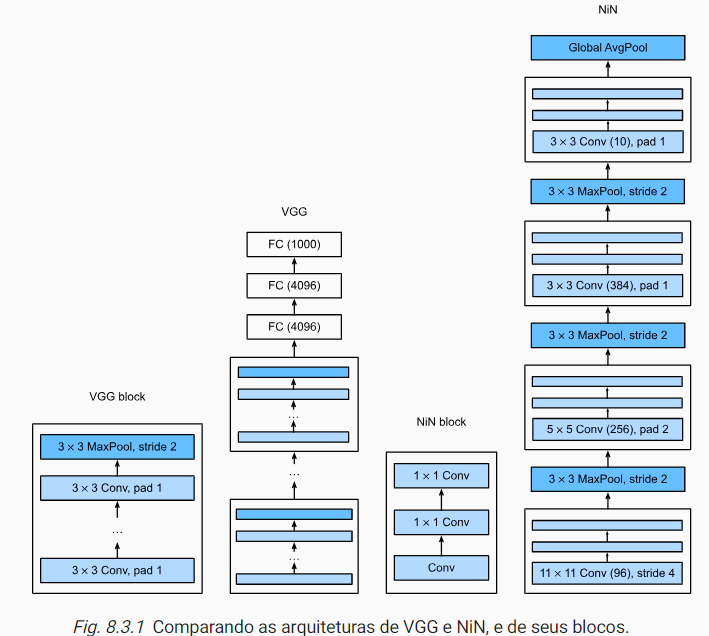

In [2]:
def nin_block(out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.LazyConv2d(out_channels, kernel_size, strides, padding), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU())

# 8.3.2. Modelo NiN

NiN usa os mesmos tamanhos de convolução inicial que AlexNet (foi proposto logo depois). Os tamanhos do kernel são 11x11, 5x5, e 3x3, respectivamente, e os números de canais de saída correspondem aos do AlexNet. Cada bloco NiN é seguido por uma camada de pooling máximo com um passo de 2 e um formato de janela de 3x3.

- A segunda diferença significativa entre NiN e AlexNet e VGG é que NiN evita camadas totalmente conectadas.
- Em vez disso, NiN usa um bloco NiN com um número de canais de saída igual ao número de classes de rótulos, seguido por uma camada de pooling de média global , produzindo um vetor de logits. 
- Este design reduz significativamente o número de parâmetros de modelo necessários, embora às custas de um aumento potencial no tempo de treinamento.


In [3]:
class NiN(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nin_block(96, kernel_size=11, strides=4, padding=0),    # Saída: [(224-11+2*0//4)+1] = 54
            nn.MaxPool2d(3, stride=2),
            nin_block(256, kernel_size=5, strides=1, padding=2),
            nn.MaxPool2d(3, stride=2),
            nin_block(384, kernel_size=3, strides=1, padding=1),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(0.5),
            nin_block(num_classes, kernel_size=3, strides=1, padding=1),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten())
        self.net.apply(d2l.init_cnn)                                # aplica a inicialização Xavier 

Criamos um exemplo de dados para ver o formato de saída de cada bloco.

In [4]:
NiN().layer_summary((1, 1, 224, 224))

C:\Users\zeh\pythonProject\.venv\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


# 8.3.3. Treinamento

Como antes, usamos o Fashion-MNIST para treinar o modelo usando o mesmo otimizador que usamos para AlexNet e VGG.

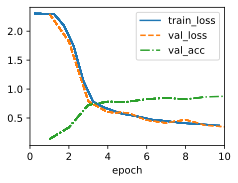

In [6]:
model = NiN(lr=0.05)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

# 8.3.4. Resumo

NiN tem dramaticamente menos parâmetros do que AlexNet e VGG. Isso decorre principalmente do fato de que ele não precisa de camadas gigantes totalmente conectadas. Em vez disso, ele usa o pooling médio global para agregar em todos os locais de imagem após o último estágio do corpo da rede. Isso elimina a necessidade de operações de redução caras (aprendidas) e as substitui por uma média simples. O que surpreendeu os pesquisadores na época foi o fato de que essa operação de média não prejudicou a precisão.

Escolhendo menos convoluções com núcleos largos e substituindo-as por 1x1 convoluções auxiliam ainda mais na busca por menos parâmetros.

----------------------------

In [7]:
# -----------------------------------------------------------------------------------------------------
# SALVA PARÂMETROS TREINADOS
torch.save(model.state_dict(), 'NiN.params')                    # salva todos os parâmetros do modelo treinado.
 #  EXTENSÃO PARA PARÂMETROS: .params

[(name, param.shape) for name, param in model.named_parameters()]   # nomes dos parâmetros



[('net.0.0.weight', torch.Size([96, 1, 11, 11])),
 ('net.0.0.bias', torch.Size([96])),
 ('net.0.2.weight', torch.Size([96, 96, 1, 1])),
 ('net.0.2.bias', torch.Size([96])),
 ('net.0.4.weight', torch.Size([96, 96, 1, 1])),
 ('net.0.4.bias', torch.Size([96])),
 ('net.2.0.weight', torch.Size([256, 96, 5, 5])),
 ('net.2.0.bias', torch.Size([256])),
 ('net.2.2.weight', torch.Size([256, 256, 1, 1])),
 ('net.2.2.bias', torch.Size([256])),
 ('net.2.4.weight', torch.Size([256, 256, 1, 1])),
 ('net.2.4.bias', torch.Size([256])),
 ('net.4.0.weight', torch.Size([384, 256, 3, 3])),
 ('net.4.0.bias', torch.Size([384])),
 ('net.4.2.weight', torch.Size([384, 384, 1, 1])),
 ('net.4.2.bias', torch.Size([384])),
 ('net.4.4.weight', torch.Size([384, 384, 1, 1])),
 ('net.4.4.bias', torch.Size([384])),
 ('net.7.0.weight', torch.Size([10, 384, 3, 3])),
 ('net.7.0.bias', torch.Size([10])),
 ('net.7.2.weight', torch.Size([10, 10, 1, 1])),
 ('net.7.2.bias', torch.Size([10])),
 ('net.7.4.weight', torch.Size([10,

In [8]:

# LOAD PARAMS:
# Recuperar/carregar os parâmetros salvos.
clone = model                                  # instanciamos um clone do modelo MLP original. É possível usar clone ou model.
clone.load_state_dict(torch.load('NiN.params'))  # lemos os parâmetros armazenados no arquivo diretamente.
clone.eval()
 #  EXTENSÃO PARA PARÂMETROS: .params
# -----------------------------------------------------------------------------------------------------


NiN(
  (net): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4))
      (1): ReLU()
      (2): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
      (3): ReLU()
      (4): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
      (5): ReLU()
    )
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Sequential(
      (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
      (3): ReLU()
      (4): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
      (5): ReLU()
    )
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1))
      (3): ReLU()
      (4): Conv2d(384, 384, kernel_size=(1, 1), stride=(1

In [12]:
# SUMÁRIO DETALHADO: size(224,224)
# ------------------------------------
from torchsummary import summary

def stat_params(net, params):
    for idx, module in enumerate(net):
        if type(module) not in (nn.Linear,nn.Conv2d):
            continue
        num = sum(p.numel() for p in module.parameters())
        if type(module) == nn.Conv2d:
            params['conv'] += num
        else:
            params['lr'] += num


model = NiN(lr=0.05)
X = torch.randn(1,3, 224, 224)
_ = model(X)
params = {'conv':0, 'lr':0}
for idx, module in enumerate(model.net):
    if type(module) == nn.Sequential:
        stat_params(module,params)
    if type(module) == nn.Linear:
        num = sum(p.numel() for p in module.parameters())
        params['lr'] += num

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

summary(model, (3, 224, 224))
params


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 54, 54]          34,944
              ReLU-2           [-1, 96, 54, 54]               0
            Conv2d-3           [-1, 96, 54, 54]           9,312
              ReLU-4           [-1, 96, 54, 54]               0
            Conv2d-5           [-1, 96, 54, 54]           9,312
              ReLU-6           [-1, 96, 54, 54]               0
         MaxPool2d-7           [-1, 96, 26, 26]               0
            Conv2d-8          [-1, 256, 26, 26]         614,656
              ReLU-9          [-1, 256, 26, 26]               0
           Conv2d-10          [-1, 256, 26, 26]          65,792
             ReLU-11          [-1, 256, 26, 26]               0
           Conv2d-12          [-1, 256, 26, 26]          65,792
             ReLU-13          [-1, 256, 26, 26]               0
        MaxPool2d-14          [-1, 256,

{'conv': 2015398, 'lr': 0}

-----------------------------------------------------------------
-----------------------------------------------------------------
---VGG:

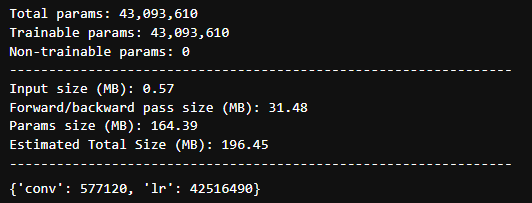



In [14]:
43093610/2015398

21.382183568704544

NiN gasta 21,38 menos parâmetros que VGG

In [15]:
196.45/32.46

6.052064078866296

NiN consome 6,05 menos memória que VGG

-----------------------

-------------------------

# Código Agrupado

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

# ------------------------------------------------------------------------------------
# ALTERANDO O CÓDIGO PARA ELIMINAR ERRO DE DATALOADER AO RODAR NO PYCHARM:
# FAZER num_workers=0 NA CLASSE FashionMNIST.

# return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
#                                    num_workers=0)

# ALTERO APENAS A FUNÇÃO ESPECÍFICA DA CLASSE ORIGINAL UTILIZANDO DECORATOR.
@d2l.add_to_class(d2l.FashionMNIST)
def get_dataloader(self, train):
    """Defined in :numref:`sec_fashion_mnist`"""
    data = self.train if train else self.val
    return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                       num_workers=0)

# -----------------------------------------------------------------------------------------------------
def nin_block(out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.LazyConv2d(out_channels, kernel_size, strides, padding), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU())

# -----------------------------------------------------------------------------------------------------
class NiN(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nin_block(96, kernel_size=11, strides=4, padding=0),    # Saída: [(224-11+2*0//4)+1] = 54
            nn.MaxPool2d(3, stride=2),
            nin_block(256, kernel_size=5, strides=1, padding=2),
            nn.MaxPool2d(3, stride=2),
            nin_block(384, kernel_size=3, strides=1, padding=1),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(0.5),
            nin_block(num_classes, kernel_size=3, strides=1, padding=1),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten())
        self.net.apply(d2l.init_cnn)                                # aplica a inicialização Xavier 

# -----------------------------------------------------------------------------------------------------
NiN().layer_summary((1, 1, 224, 224))

# -----------------------------------------------------------------------------------------------------
model = NiN(lr=0.05)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)


# -----------------------------------------------------------------------------------------------------
# SALVA PARÂMETROS TREINADOS
torch.save(model.state_dict(), 'NiN.params')                    # salva todos os parâmetros do modelo treinado.
 #  EXTENSÃO PARA PARÂMETROS: .params

[(name, param.shape) for name, param in model.named_parameters()]   # nomes dos parâmetros



# -----------------------------------------------------------------------------------------------------
# LOAD PARAMS:
# Recuperar/carregar os parâmetros salvos.
clone = model                                  # instanciamos um clone do modelo MLP original. É possível usar clone ou model.
clone.load_state_dict(torch.load('NiN.params'))  # lemos os parâmetros armazenados no arquivo diretamente.
clone.eval()
 #  EXTENSÃO PARA PARÂMETROS: .params
# -----------------------------------------------------------------------------------------------------


# -----------------------------------------------------------------------------------------------------
# SUMÁRIO DETALHADO: size(224,224)
# ------------------------------------
from torchsummary import summary

def stat_params(net, params):
    for idx, module in enumerate(net):
        if type(module) not in (nn.Linear,nn.Conv2d):
            continue
        num = sum(p.numel() for p in module.parameters())
        if type(module) == nn.Conv2d:
            params['conv'] += num
        else:
            params['lr'] += num


model = NiN(lr=0.05)
X = torch.randn(1,3, 224, 224)
_ = model(X)
params = {'conv':0, 'lr':0}
for idx, module in enumerate(model.net):
    if type(module) == nn.Sequential:
        stat_params(module,params)
    if type(module) == nn.Linear:
        num = sum(p.numel() for p in module.parameters())
        params['lr'] += num

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

summary(model, (3, 224, 224))
params
# -----------------------------------------------------------------------------------------------------






# 8.3.5. Exercícios

# Ex. 1 - Por que existem dois 1x1 camadas convolucionais por bloco de NiN? Aumente seu número para três. Reduza seu número para um. O que muda?

In [22]:
# 3 camadas convolucionais 1x1:
import torch
from torch import nn
from d2l import torch as d2l

# ------------------------------------------------------------------------------------
# ALTERANDO O CÓDIGO PARA ELIMINAR ERRO DE DATALOADER AO RODAR NO PYCHARM:
# FAZER num_workers=0 NA CLASSE FashionMNIST.

# return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
#                                    num_workers=0)

# ALTERO APENAS A FUNÇÃO ESPECÍFICA DA CLASSE ORIGINAL UTILIZANDO DECORATOR.
@d2l.add_to_class(d2l.FashionMNIST)
def get_dataloader(self, train):
    """Defined in :numref:`sec_fashion_mnist`"""
    data = self.train if train else self.val
    return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                       num_workers=0)

# -----------------------------------------------------------------------------------------------------
def nin_block(out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.LazyConv2d(out_channels, kernel_size, strides, padding), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU())

# -----------------------------------------------------------------------------------------------------
class NiN(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nin_block(96, kernel_size=11, strides=4, padding=0),    # Saída: [(224-11+2*0//4)+1] = 54
            nn.MaxPool2d(3, stride=2),
            nin_block(256, kernel_size=5, strides=1, padding=2),
            nn.MaxPool2d(3, stride=2),
            nin_block(384, kernel_size=3, strides=1, padding=1),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(0.5),
            nin_block(num_classes, kernel_size=3, strides=1, padding=1),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten())
        self.net.apply(d2l.init_cnn)                                # aplica a inicialização Xavier

# -----------------------------------------------------------------------------------------------------
NiN().layer_summary((1, 1, 224, 224))

# -----------------------------------------------------------------------------------------------------
model = NiN(lr=0.05)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
# trainer.fit(model, data)


# -----------------------------------------------------------------------------------------------------
# # SALVA PARÂMETROS TREINADOS
# torch.save(model.state_dict(), 'NiN.params')                    # salva todos os parâmetros do modelo treinado.
#  #  EXTENSÃO PARA PARÂMETROS: .params
#
# [(name, param.shape) for name, param in model.named_parameters()]   # nomes dos parâmetros
#


# # -----------------------------------------------------------------------------------------------------
# # LOAD PARAMS:
# # Recuperar/carregar os parâmetros salvos.
# clone = model                                  # instanciamos um clone do modelo MLP original. É possível usar clone ou model.
# clone.load_state_dict(torch.load('NiN.params'))  # lemos os parâmetros armazenados no arquivo diretamente.
# clone.eval()
#  #  EXTENSÃO PARA PARÂMETROS: .params
# # -----------------------------------------------------------------------------------------------------


# -----------------------------------------------------------------------------------------------------
# SUMÁRIO DETALHADO: size(224,224)
# ------------------------------------
from torchsummary import summary

def stat_params(net, params):
    for idx, module in enumerate(net):
        if type(module) not in (nn.Linear,nn.Conv2d):
            continue
        num = sum(p.numel() for p in module.parameters())
        if type(module) == nn.Conv2d:
            params['conv'] += num
        else:
            params['lr'] += num


model = NiN(lr=0.05)
X = torch.randn(1,3, 224, 224)
_ = model(X)
params = {'conv':0, 'lr':0}
for idx, module in enumerate(model.net):
    if type(module) == nn.Sequential:
        stat_params(module,params)
    if type(module) == nn.Linear:
        num = sum(p.numel() for p in module.parameters())
        params['lr'] += num

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

summary(model, (3, 224, 224))
params
# -----------------------------------------------------------------------------------------------------






Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 54, 54]          34,944
              ReLU-2           [-1, 96, 54, 54]               0
            Conv2d-3           [-1, 96, 54, 54]           9,312
              ReLU-4           [-1, 96, 54, 54]               0
            Conv2d-5           [-1, 96, 54, 54]           9,312
              ReLU-6    

{'conv': 2238452, 'lr': 0}

In [23]:
# 1 camada convolucional 1x1:
import torch
from torch import nn
from d2l import torch as d2l

# ------------------------------------------------------------------------------------
# ALTERANDO O CÓDIGO PARA ELIMINAR ERRO DE DATALOADER AO RODAR NO PYCHARM:
# FAZER num_workers=0 NA CLASSE FashionMNIST.

# return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
#                                    num_workers=0)

# ALTERO APENAS A FUNÇÃO ESPECÍFICA DA CLASSE ORIGINAL UTILIZANDO DECORATOR.
@d2l.add_to_class(d2l.FashionMNIST)
def get_dataloader(self, train):
    """Defined in :numref:`sec_fashion_mnist`"""
    data = self.train if train else self.val
    return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                       num_workers=0)

# -----------------------------------------------------------------------------------------------------
def nin_block(out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.LazyConv2d(out_channels, kernel_size, strides, padding), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU())

# -----------------------------------------------------------------------------------------------------
class NiN(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nin_block(96, kernel_size=11, strides=4, padding=0),    # Saída: [(224-11+2*0//4)+1] = 54
            nn.MaxPool2d(3, stride=2),
            nin_block(256, kernel_size=5, strides=1, padding=2),
            nn.MaxPool2d(3, stride=2),
            nin_block(384, kernel_size=3, strides=1, padding=1),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(0.5),
            nin_block(num_classes, kernel_size=3, strides=1, padding=1),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten())
        self.net.apply(d2l.init_cnn)                                # aplica a inicialização Xavier

# -----------------------------------------------------------------------------------------------------
NiN().layer_summary((1, 1, 224, 224))

# -----------------------------------------------------------------------------------------------------
model = NiN(lr=0.05)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
# trainer.fit(model, data)


# -----------------------------------------------------------------------------------------------------
# # SALVA PARÂMETROS TREINADOS
# torch.save(model.state_dict(), 'NiN.params')                    # salva todos os parâmetros do modelo treinado.
#  #  EXTENSÃO PARA PARÂMETROS: .params
#
# [(name, param.shape) for name, param in model.named_parameters()]   # nomes dos parâmetros
#


# # -----------------------------------------------------------------------------------------------------
# # LOAD PARAMS:
# # Recuperar/carregar os parâmetros salvos.
# clone = model                                  # instanciamos um clone do modelo MLP original. É possível usar clone ou model.
# clone.load_state_dict(torch.load('NiN.params'))  # lemos os parâmetros armazenados no arquivo diretamente.
# clone.eval()
#  #  EXTENSÃO PARA PARÂMETROS: .params
# # -----------------------------------------------------------------------------------------------------


# -----------------------------------------------------------------------------------------------------
# SUMÁRIO DETALHADO: size(224,224)
# ------------------------------------
from torchsummary import summary

def stat_params(net, params):
    for idx, module in enumerate(net):
        if type(module) not in (nn.Linear,nn.Conv2d):
            continue
        num = sum(p.numel() for p in module.parameters())
        if type(module) == nn.Conv2d:
            params['conv'] += num
        else:
            params['lr'] += num


model = NiN(lr=0.05)
X = torch.randn(1,3, 224, 224)
_ = model(X)
params = {'conv':0, 'lr':0}
for idx, module in enumerate(model.net):
    if type(module) == nn.Sequential:
        stat_params(module,params)
    if type(module) == nn.Linear:
        num = sum(p.numel() for p in module.parameters())
        params['lr'] += num

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

summary(model, (3, 224, 224))
params
# -----------------------------------------------------------------------------------------------------






Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 54, 54]          34,944
              ReLU-2           [-1, 96, 54, 54]               0
            Conv2d-3           [-1, 96, 54, 54]           9,312
              ReLU-4           [-1, 96, 54, 54]               0
         MaxPool2d-5           [-1, 96, 26, 26]               0
            Conv2d-6    

{'conv': 1792344, 'lr': 0}

Quanto mais camadas convolucionais 1x1 utilizadas, maior são a quantidade de parâmetros utilizados

# Ex. 2 - O que muda se você substituir o 1x1 convoluções por 3x3 convoluções?

In [29]:
# 1 camada convolucional 1x1:
import torch
from torch import nn
from d2l import torch as d2l

# ------------------------------------------------------------------------------------
# ALTERANDO O CÓDIGO PARA ELIMINAR ERRO DE DATALOADER AO RODAR NO PYCHARM:
# FAZER num_workers=0 NA CLASSE FashionMNIST.

# return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
#                                    num_workers=0)

# ALTERO APENAS A FUNÇÃO ESPECÍFICA DA CLASSE ORIGINAL UTILIZANDO DECORATOR.
@d2l.add_to_class(d2l.FashionMNIST)
def get_dataloader(self, train):
    """Defined in :numref:`sec_fashion_mnist`"""
    data = self.train if train else self.val
    return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                       num_workers=0)

# -----------------------------------------------------------------------------------------------------
def nin_block(out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.LazyConv2d(out_channels, kernel_size, strides, padding), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=3, padding=1), nn.ReLU(),           # É necessário adicionar padding=1  
        nn.LazyConv2d(out_channels, kernel_size=3, padding=1), nn.ReLU())           # É necessário adicionar padding=1  

# -----------------------------------------------------------------------------------------------------
class NiN(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nin_block(96, kernel_size=11, strides=4, padding=0),    # Saída: [(224-11+2*0//4)+1] = 54
            nn.MaxPool2d(3, stride=2),
            nin_block(256, kernel_size=5, strides=1, padding=2),
            nn.MaxPool2d(3, stride=2),
            nin_block(384, kernel_size=3, strides=1, padding=1),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(0.5),
            nin_block(num_classes, kernel_size=3, strides=1, padding=1),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten())
        self.net.apply(d2l.init_cnn)                                # aplica a inicialização Xavier

# -----------------------------------------------------------------------------------------------------
NiN().layer_summary((1, 1, 224, 224))

# -----------------------------------------------------------------------------------------------------
model = NiN(lr=0.05)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
# trainer.fit(model, data)


# -----------------------------------------------------------------------------------------------------
# # SALVA PARÂMETROS TREINADOS
# torch.save(model.state_dict(), 'NiN.params')                    # salva todos os parâmetros do modelo treinado.
#  #  EXTENSÃO PARA PARÂMETROS: .params
#
# [(name, param.shape) for name, param in model.named_parameters()]   # nomes dos parâmetros
#


# # -----------------------------------------------------------------------------------------------------
# # LOAD PARAMS:
# # Recuperar/carregar os parâmetros salvos.
# clone = model                                  # instanciamos um clone do modelo MLP original. É possível usar clone ou model.
# clone.load_state_dict(torch.load('NiN.params'))  # lemos os parâmetros armazenados no arquivo diretamente.
# clone.eval()
#  #  EXTENSÃO PARA PARÂMETROS: .params
# # -----------------------------------------------------------------------------------------------------


# -----------------------------------------------------------------------------------------------------
# SUMÁRIO DETALHADO: size(224,224)
# ------------------------------------
from torchsummary import summary

def stat_params(net, params):
    for idx, module in enumerate(net):
        if type(module) not in (nn.Linear,nn.Conv2d):
            continue
        num = sum(p.numel() for p in module.parameters())
        if type(module) == nn.Conv2d:
            params['conv'] += num
        else:
            params['lr'] += num


model = NiN(lr=0.05)
X = torch.randn(1,3, 224, 224)
_ = model(X)
params = {'conv':0, 'lr':0}
for idx, module in enumerate(model.net):
    if type(module) == nn.Sequential:
        stat_params(module,params)
    if type(module) == nn.Linear:
        num = sum(p.numel() for p in module.parameters())
        params['lr'] += num

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

summary(model, (3, 224, 224))
params
# -----------------------------------------------------------------------------------------------------






Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 54, 54]          34,944
              ReLU-2           [-1, 96, 54, 54]               0
            Conv2d-3           [-1, 96, 54, 54]          83,040
              ReLU-4           [-1, 96, 54, 54]               0
            Conv2d-5           [-1, 96, 54, 54]          83,040
              ReLU-6    

{'conv': 5572326, 'lr': 0}

A quantidade de parâmetros sobe de 2.015.398 (7,69 Mb) para 5.572.326 (21.26 Mb)

# Ex. 3 - O que acontece se você substituir o pool médio global por uma camada totalmente conectada (velocidade, precisão, número de parâmetros)?

In [30]:
import torch
from torch import nn
from d2l import torch as d2l

# ------------------------------------------------------------------------------------
# ALTERANDO O CÓDIGO PARA ELIMINAR ERRO DE DATALOADER AO RODAR NO PYCHARM:
# FAZER num_workers=0 NA CLASSE FashionMNIST.

# return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
#                                    num_workers=0)

# ALTERO APENAS A FUNÇÃO ESPECÍFICA DA CLASSE ORIGINAL UTILIZANDO DECORATOR.
@d2l.add_to_class(d2l.FashionMNIST)
def get_dataloader(self, train):
    """Defined in :numref:`sec_fashion_mnist`"""
    data = self.train if train else self.val
    return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                       num_workers=0)

# -----------------------------------------------------------------------------------------------------
def nin_block(out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.LazyConv2d(out_channels, kernel_size, strides, padding), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU())

# -----------------------------------------------------------------------------------------------------
class NiN(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nin_block(96, kernel_size=11, strides=4, padding=0),    # Saída: [(224-11+2*0//4)+1] = 54
            nn.MaxPool2d(3, stride=2),
            nin_block(256, kernel_size=5, strides=1, padding=2),
            nn.MaxPool2d(3, stride=2),
            nin_block(384, kernel_size=3, strides=1, padding=1),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(0.5),
            nin_block(num_classes, kernel_size=3, strides=1, padding=1),
            # nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)                                # aplica a inicialização Xavier

# -----------------------------------------------------------------------------------------------------
NiN().layer_summary((1, 1, 224, 224))

# -----------------------------------------------------------------------------------------------------
model = NiN(lr=0.05)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
# trainer.fit(model, data)


# # -----------------------------------------------------------------------------------------------------
# # SALVA PARÂMETROS TREINADOS
# torch.save(model.state_dict(), 'NiN.params')                    # salva todos os parâmetros do modelo treinado.
#  #  EXTENSÃO PARA PARÂMETROS: .params
#
# [(name, param.shape) for name, param in model.named_parameters()]   # nomes dos parâmetros
#


# -----------------------------------------------------------------------------------------------------
# # LOAD PARAMS:
# # Recuperar/carregar os parâmetros salvos.
# clone = model                                  # instanciamos um clone do modelo MLP original. É possível usar clone ou model.
# clone.load_state_dict(torch.load('NiN.params'))  # lemos os parâmetros armazenados no arquivo diretamente.
# clone.eval()
#  #  EXTENSÃO PARA PARÂMETROS: .params
# # -----------------------------------------------------------------------------------------------------
#

# -----------------------------------------------------------------------------------------------------
# SUMÁRIO DETALHADO: size(224,224)
# ------------------------------------
from torchsummary import summary

def stat_params(net, params):
    for idx, module in enumerate(net):
        if type(module) not in (nn.Linear,nn.Conv2d):
            continue
        num = sum(p.numel() for p in module.parameters())
        if type(module) == nn.Conv2d:
            params['conv'] += num
        else:
            params['lr'] += num


model = NiN(lr=0.05)
X = torch.randn(1,3, 224, 224)
_ = model(X)
params = {'conv':0, 'lr':0}
for idx, module in enumerate(model.net):
    if type(module) == nn.Sequential:
        stat_params(module,params)
    if type(module) == nn.Linear:
        num = sum(p.numel() for p in module.parameters())
        params['lr'] += num

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

summary(model, (3, 224, 224))
params
# -----------------------------------------------------------------------------------------------------






Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
Flatten output shape:	 torch.Size([1, 250])
Linear output shape:	 torch.Size([1, 10])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 54, 54]          34,944
              ReLU-2           [-1, 96, 54, 54]               0
            Conv2d-3           [-1, 96, 54, 54]           9,312
              ReLU-4           [-1, 96, 54, 54]               0
            Conv2d-5           [-1, 96, 54, 54]           9,312
              ReLU-6           [-1, 96, 

{'conv': 2015398, 'lr': 2510}

- O número de parâmetros permanece semelhante.

# Ex. 4 - Calcule o uso de recursos para NiN.

- Qual é o número de parâmetros?

In [36]:
import torch
from torch import nn
from d2l import torch as d2l

# ------------------------------------------------------------------------------------
# ALTERANDO O CÓDIGO PARA ELIMINAR ERRO DE DATALOADER AO RODAR NO PYCHARM:
# FAZER num_workers=0 NA CLASSE FashionMNIST.

# return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
#                                    num_workers=0)

# ALTERO APENAS A FUNÇÃO ESPECÍFICA DA CLASSE ORIGINAL UTILIZANDO DECORATOR.
@d2l.add_to_class(d2l.FashionMNIST)
def get_dataloader(self, train):
    """Defined in :numref:`sec_fashion_mnist`"""
    data = self.train if train else self.val
    return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                       num_workers=0)

# -----------------------------------------------------------------------------------------------------
def nin_block(out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.LazyConv2d(out_channels, kernel_size, strides, padding), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU())

# -----------------------------------------------------------------------------------------------------
class NiN(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nin_block(96, kernel_size=11, strides=4, padding=0),    # Saída: [(224-11+2*0//4)+1] = 54
            nn.MaxPool2d(3, stride=2),
            nin_block(256, kernel_size=5, strides=1, padding=2),
            nn.MaxPool2d(3, stride=2),
            nin_block(384, kernel_size=3, strides=1, padding=1),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(0.5),
            nin_block(num_classes, kernel_size=3, strides=1, padding=1),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten())
        self.net.apply(d2l.init_cnn)                                # aplica a inicialização Xavier 

# -----------------------------------------------------------------------------------------------------
NiN().layer_summary((1, 1, 224, 224))

# -----------------------------------------------------------------------------------------------------
model = NiN(lr=0.05)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
# trainer.fit(model, data)


# -----------------------------------------------------------------------------------------------------
# SALVA PARÂMETROS TREINADOS
torch.save(model.state_dict(), 'NiN.params')                    # salva todos os parâmetros do modelo treinado.
 #  EXTENSÃO PARA PARÂMETROS: .params

[(name, param.shape) for name, param in model.named_parameters()]   # nomes dos parâmetros



# -----------------------------------------------------------------------------------------------------
# LOAD PARAMS:
# Recuperar/carregar os parâmetros salvos.
clone = model                                  # instanciamos um clone do modelo MLP original. É possível usar clone ou model.
clone.load_state_dict(torch.load('NiN.params'))  # lemos os parâmetros armazenados no arquivo diretamente.
clone.eval()
 #  EXTENSÃO PARA PARÂMETROS: .params
# -----------------------------------------------------------------------------------------------------


# -----------------------------------------------------------------------------------------------------
# SUMÁRIO DETALHADO: size(224,224)
# ------------------------------------
from torchsummary import summary

def stat_params(net, params):
    for idx, module in enumerate(net):
        if type(module) not in (nn.Linear,nn.Conv2d):
            continue
        num = sum(p.numel() for p in module.parameters())
        if type(module) == nn.Conv2d:
            params['conv'] += num
        else:
            params['lr'] += num


model = NiN(lr=0.05)
X = torch.randn(1,3, 224, 224)
_ = model(X)
params = {'conv':0, 'lr':0}
for idx, module in enumerate(model.net):
    if type(module) == nn.Sequential:
        stat_params(module,params)
    if type(module) == nn.Linear:
        num = sum(p.numel() for p in module.parameters())
        params['lr'] += num

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

summary(model, (3, 224, 224))
params
# -----------------------------------------------------------------------------------------------------






Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 54, 54]          34,944
              ReLU-2           [-1, 96, 54, 54]               0
            Conv2d-3           [-1, 96, 54, 54]           9,312
              ReLU-4           [-1, 96, 54, 54]               0
            Conv2d-5           [-1, 96, 54, 54]           9,312
              ReLU-6    

{'conv': 2015398, 'lr': 0}

- Qual é a quantidade de computação?

In [46]:
from thop import profile

# model = NiN(lr=0.05)
model = clone                       # clone já possui os parâmetros treinados
X = torch.randn(1,1, 224, 224)

flops, params = profile(model, inputs=(X,))

print("Total FLOPs:", flops)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
Total FLOPs: 2286892836.0


FLOPS, or floating-point operations per second, is a metric for computer performance that quantifies the number of floating-point calculations a system can perform in one second.

I not sure my answer is 100% correct. but this is what i understand.

- FLOPS = Floating point operations per second

- FLOPs = Floating point operations

FLOPS is a unit of speed. FLOPs is a unit of amount.

Example Consider a deep learning model that processes images. The number of FLOPS required to run this model gives an idea of how computationally intensive it is. If a model requires 1 billion FLOPS to process one image, and your GPU can handle 5 billion FLOPS per second, it means your GPU can process 5 images per second.

FLOPS vs. FLOP FLOP (Floating Point Operation) refers to a single floating-point calculation. FLOPS (Floating Point Operations Per Second) measures how many such operations can be performed in one second.

Practical Use

When optimizing a deep learning model, you might aim to reduce the number of FLOPS required to make it run faster on available hardware. Conversely, when choosing hardware, you might look for higher FLOPS to ensure it can handle complex models efficiently.

In summary, FLOPS is a key metric in deep learning that helps gauge the computational power needed to train and run models, ensuring efficient and effective use of hardware resources.

https://stackoverflow.com/questions/58498651/what-is-flops-in-field-of-deep-learning

- Qual é a quantidade de memória necessária durante o treinamento?

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize memory counters
torch.cuda.reset_peak_memory_stats()
torch.cuda.empty_cache()
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
trainer.fit(model, data)
memory_stats = torch.cuda.memory_stats(device=device)
# Print peak memory usage and other memory statistics
print("Peak memory usage:", memory_stats["allocated_bytes.all.peak"] / (1024 ** 2), "MB")
print("Current memory usage:", memory_stats["allocated_bytes.all.current"] / (1024 ** 2), "MB")

- Qual é a quantidade de memória necessária durante a previsão?

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.reset_peak_memory_stats()
torch.cuda.empty_cache()

# model = clone                       # clone já possui os parâmetros treinados
model = NiN(lr=0.05)
X = torch.randn(1,1, 224, 224)

_ = model(X)
memory_stats = torch.cuda.memory_stats(device=device)
print("Peak memory usage:", memory_stats["allocated_bytes.all.peak"] / (1024 ** 2), "MB")
print("Current memory usage:", memory_stats["allocated_bytes.all.current"] / (1024 ** 2), "MB")

Peak memory usage: 55.509765625 MB
Current memory usage: 47.8193359375 MB


# Ex. 5 - Quais são os possíveis problemas com a redução do 384x5x5 representação para um 10x5x5 representação em uma etapa?

- Perda de informação.
- Underfitting - pobre generalização e desempenho.

To mitigate these problems, it’s common to use intermediate layers with smaller reductions in the number of channels, allowing the network to learn gradually more abstract and complex features. The NiN architecture typically uses multiple consecutive NiN blocks to avoid these issues by applying multiple nonlinear transformations with 1×1 convolutions, gradually reducing the number of channels over several steps, and maintaining the network’s ability to learn meaningful representations.

# Outras respostas:

https://pandalab.me/archives/nin#google_vignette